## Models to be used
1. elongate (accumulate temperature computation)
2. senescent (aging relevant computation)
3. growth   (mass increasing)
4. farquhar (photosynthesis)
5. cn       (translocation)   
6. respiration

## REMARKs
1. use tatantive meteorological data in farquhar model for photosynthesis calculation
2. respiration model is called only inside the growth model and the cn model
3. the "calculate_surfacic_WSC" function in farquharwheat should removes the fructan contents
4. the fructan relevant computation in cn model should be removed by the same reason.
5. remove the internode/sheath/penducle entries in the input file, so that only calculate the photosynthesis on leaves.
6. in cn model the temperature of air and soil is deliberately updated for a finer granularity
7. all the models have their corresponding facade file to handle MTG read/write, and initialize their localized data structure up-to time. This should be altered to refer to the real-time computation results by sharing a common data record (e.g. pandas.DataFrame) on the fly.
8. in senescent model, only consider the postflowering stage.
9. in senescent model, the calculation for length is omitted.
10. in farquhar model, 'height_canopy' in axis is set as the maximum value among the 'height' of all the elements 
11. in elongtation model, 'SAM_height' is not used in effect. For 'SAM_height' is evaluate according to 'below_internode_lengths,' but its calculation is disabled in 'elongwheat_facade.py' for the assertion 'if set(mtg_element_properties).issuperset(simulation.ELEMENT_INPUTS)' is always false.
12. use the newest ambient CO2 for farquhar calculation
13. remove all the computation relevant to 'hiddenzone'

sidenote: keep in mind that in python, mutable object such as list and array is assigned by reference, whereas immutable object such as string is assigned by value.

In [15]:
import numpy as np
from matplotlib import pyplot as plt
D0 = 2
ci_cs = 0.98
GAMMA25 = 39
An = 30
cs = 300

def RH2VPD(RH, Ts=25, Pa=101):
    a = 611.21
    b = 17.502
    c = 240.97
    f = 1.0007+3.46*1E-8*Pa*1000
    esatval = f*a*(np.exp(b*Ts/(c+Ts)))
    e = RH/100*esatval
    return (esatval-e)/1000

def old_formula(RH, input_cs):
    gsc = An*0.05*RH/input_cs
    return gsc

def new_formula(Ds, input_cs):
    gsc = 0.05+An/((input_cs-GAMMA25)*(1+Ds/D0))
    return gsc

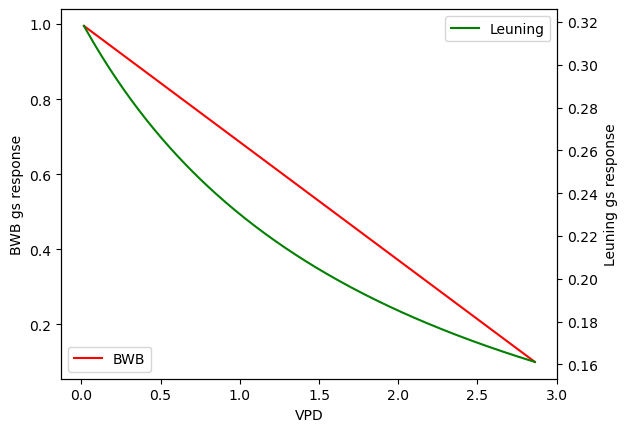

In [16]:
RH = np.arange(10,100,0.5)
test_cs = np.arange(100, 400, 0.5)
convertedVPD = [RH2VPD(rrh) for rrh in RH]
old_gsc_response = [old_formula(rrh, 150) for rrh in RH]
new_gsc_response = [new_formula(RH2VPD(rrh), 150) for rrh in RH]

fig, ax1 = plt.subplots()
ax1.plot(convertedVPD, old_gsc_response, 'r', label='BWB')
ax1.set_xlabel('VPD')
ax1.set_ylabel('BWB gs response')
ax2 = ax1.twinx()
ax2.plot(convertedVPD, new_gsc_response, 'g', label='Leuning')
ax2.set_ylabel('Leuning gs response')
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')

In [16]:
from alinea.adel.adel_dynamic import AdelDyn
from alinea.adel.Stand import AgronomicStand
from alinea.adel.adel import Adel
from openalea.plantgl.all import Viewer, Scene
from openalea.mtg import MTG
import os
from alinea.adel.geometric_elements import Leaves
from alinea.adel.mtg_interpreter import transform_geom
from alinea.adel.newmtg import internode_elements, sheath_elements, blade_elements, convert, properties_from_dict, adel_metamer

In [67]:
leaf_creator = Leaves()
g = MTG()
root = g.root
plant = g.add_component(root, edge_type='/', label='plant') # scale = 1
main_stem = g.add_component(plant, edge_type='/', label='MS', azimuth=60) # scale = 2
metamer = g.add_component(main_stem, edge_type='/', label='metamer0') # scale = 3
blade = g.add_component(metamer, edge_type='/', label='blade', shape_key=leaf_creator.get_leaf_key(1,1,None), 
                        shape_mature_length=0.189382464, shape_max_width=0.011911594, 
                        visible_length=0.15, incline=30, species=0, inclination=30) # scale = 4
base_element = g.add_component(blade, edge_type='/', label='baseElement') # scale = 4
leaf_element = g.add_child(base_element, edge_type='<', label='LeafElement1', srb = 0, srt = 1, length = 0.15, lrolled=0, is_green=True) # scale = 5
top_element = g.add_child(leaf_element, edge_type='<', label='topElement')

from alinea.adel.mtg_interpreter import mtg_interpreter, plot3d, transform_geom
from openalea.plantgl.all import Viewer, Scene
update_g = mtg_interpreter(g, {0:leaf_creator})
# update_g.node(6).geometry = pgl.Translated( (1,0,0), update_g.property('geometry')[6])
Viewer.display(plot3d(update_g))
Viewer.waitSelection()

257

In [66]:
update_g.display()

MTG : nb_vertices=8, nb_scales=6
/plant			(id=1)											
^/MS			(id=2)											
^/metamer0			(id=3)											
^/blade			(id=4)											
^/baseElement			(id=5)											
^<LeafElement1			(id=6)											
^<topElement			(id=7)											


In [9]:
g = MTG()
root = g.root # scale = 0
plant = g.add_component(root, edge_type='/', label='plant')   # scale = 1
main_stem = g.add_component(plant, edge_type='/', label='MS') # scale = 2
metamer0 = g.add_component(main_stem, edge_type='/', label='metamer0')    # scale = 3
# internode
internode0 = g.add_component(metamer0, edge_type='/', label='internode0') # scale = 4
base_element = g.add_component(internode0, edge_type='/', label='baseElement') # scale = 5
hidden_element = g.add_child(base_element, edge_type='<', label='HiddenElement', )
stem_element = g.add_child(hidden_element, edge_type='<', label='StemElement')
top_element_pre = g.add_child(stem_element, edge_type = '<', label='topElement')
# sheath
sheath = g.add_child(internode0, edge_type='+', label='sheath')
base_element = g.add_component(sheath, edge_type='/', label='baseElement')
g.add_child(top_element_pre, base_element) # link the base element of the current organ to its predecessor
hidden_element = g.add_child(base_element, edge_type='<', label='HiddenElement')
stem_element = g.add_child(hidden_element, edge_type='<', label='StemElement')
top_element_pre = g.add_child(stem_element, edge_type='<', label='topElement')
# blade
blade = g.add_child(sheath, edge_type='<', label='blade') # scale = 4
base_element = g.add_component(blade, edge_type='/', label='baseElement')
g.add_child(top_element_pre, base_element)
hidden_element = g.add_child(base_element, edge_type='<', label='HiddenElement')
stem_element = g.add_child(hidden_element, edge_type='<', label='StemElement')
top_element_pre = g.add_child(stem_element, edge_type='<', label='topElement')


In [10]:
g.display()

MTG : nb_vertices=19, nb_scales=6
/plant			(id=1)											
^/MS			(id=2)											
^/metamer0			(id=3)											
^/internode0			(id=4)											
^/baseElement			(id=5)											
^<HiddenElement			(id=6)											
^<StemElement			(id=7)											
^<topElement			(id=8)											
	+sheath			(id=9)										
	^/baseElement			(id=10)										
	^<HiddenElement			(id=11)										
	^<StemElement			(id=12)										
	^<topElement			(id=13)										
	^<blade			(id=14)										
	^/baseElement			(id=15)										
	^<HiddenElement			(id=16)										
	^<StemElement			(id=17)										
	^<topElement			(id=18)										


In [2]:
import sys
sys.path.append(r"C:\Users\gyoso.cho.TIRD\source\WheatFspm\WheatFspm\elong-wheat\elongwheat")
sys.path.append(r"C:\Users\gyoso.cho.TIRD\source\WheatFspm\WheatFspm\fspm-wheat\fspmwheat")
sys.path.append(r"C:\Users\gyoso.cho.TIRD\source\WheatFspm\WheatFspm\senesc-wheat\senescwheat")
sys.path.append(r"C:\Users\gyoso.cho.TIRD\source\WheatFspm\WheatFspm\growth-wheat\growthwheat")
sys.path.append(r"C:\Users\gyoso.cho.TIRD\source\WheatFspm\WheatFspm\farquhar-wheat\farquharwheat")
sys.path.append(r"C:\Users\gyoso.cho.TIRD\source\WheatFspm\WheatFspm\cn-wheat\cnwheat")
from elongwheat import model as elong_model
from senescwheat import model as sene_model
from growthwheat import model as growth_model
from farquharwheat import model as farquhar_model, parameters as far_parameters
from cnwheat import model as cnwheat_model, parameters as cnwheat_parameters

from fspmwheat import tools

import numpy as np
import pandas as pd
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
import pandas as pd
meteorological_table = pd.DataFrame({'t': pd.Series(dtype='int'),
                                    'air_temperature': pd.Series(dtype='float'),
                                    'humidity': pd.Series(dtype='float'),
                                    'Wind': pd.Series(dtype='float'),
                                    'PARi': pd.Series(dtype='float')})
meteorological_table = meteorological_table.append({'t':0, 'air_temperature':19.1, 'humidity':0.84,
                                                   'ambient_CO2':416.35, 'Wind':2.2, 'PARi':5.61}, ignore_index=True)
meteorological_table = meteorological_table.set_index('t')

AXIS_TOPOLOGY_COLUMNS = ['plant', 'axis']
axis_table = pd.DataFrame({'plant': pd.Series(dtype='int'),'axis': pd.Series(dtype='str'),
                          'status': pd.Series(dtype='str'),'nb_leaves': pd.Series(dtype='int'),
                          'height': pd.Series(dtype='float'),'SAM_temperature': pd.Series(dtype='float'),
                          'delta_teq': pd.Series(dtype='float'),'delta_teq_roots': pd.Series(dtype='float'),
                          'sum_TT': pd.Series(dtype='float'),'cohort': pd.Series(dtype='int'),})
                          # 'minerals_plant': pd.Series(dtype='float')})
axis_table = axis_table.append({'plant': 1, 'axis': 'MS', 'status': 'reproductive', 'nb_leaves': 12,
                                'height': 120, 'SAM_temperature': 20, 'delta_teq': 3600, 
                                'delta_teq_roots': 3600, 'sum_TT':0.0,
                                'cohort': 1}, ignore_index=True)
                                #'cohort': 1, 'minerals_plant': 0.1070285}, ignore_index=True)

ORGAN_TOPOLOGY_COLUMNS = ['plant', 'axis', 'organ']
organ_table = pd.DataFrame({'plant': pd.Series(dtype='int'), 'axis': pd.Series(dtype='str'), 
                            'organ': pd.Series(dtype='str'),'sucrose': pd.Series(dtype='float'), 
                            'amino_acids': pd.Series(dtype='float'), 'nitrates': pd.Series(dtype='float'),
                           'structure': pd.Series(dtype='float'), 'starch': pd.Series(dtype='float'), 
                            'proteins': pd.Series(dtype='float'),'mstruct': pd.Series(dtype='float'), 
                            'senesced_mstruct': pd.Series(dtype='float'), 'Nstruct': pd.Series(dtype='float'),
                           'cytokinins': pd.Series(dtype='float'),'age_from_flowering': pd.Series(dtype='float'),
                           'Respi_growth': pd.Series(dtype='float'), 'AA_consumption_mstruct': pd.Series(dtype='float'),
                            'sucrose_consumption_mstruct': pd.Series(dtype='float'),'delta_mstruct_growth': pd.Series(dtype='float')                        
                           })
organ_table = organ_table.append({'plant': 1, 'axis': 'MS', 'organ': 'grains', 
                                 'sucrose': 0, 'amino_acids': 0, 'nitrates': 0,
                                 'structure': 2450, 'starch': 0, 'proteins': 107,
                                 'mstruct': 0, 'senesced_mstruct': 0,
                                 'Nstruct': 0, 'cytokinins': 0, 'age_from_flowering': 0}, ignore_index=True)
organ_table = organ_table.append({'plant': 1, 'axis': 'MS', 'organ': 'phloem',
                                 'sucrose': 831, 'amino_acids': 161, 'nitrates': 0,
                                 'structure': 0, 'starch': 0, 'proteins':0,
                                 'mstruct': 0, 'senesced_mstruct': 0, 'Nstruct':0,
                                 'cytokinins': 0, 'age_from_flowering': 0}, ignore_index=True)
organ_table = organ_table.append({'plant': 1, 'axis': 'MS', 'organ': 'roots',
                                  'sucrose': 740, 'amino_acids': 60, 'nitrates': 250, 
                                  'structure': 0, 'starch': 0, 'proteins': 0,
                                  'mstruct': 0.504, 'senesced_mstruct': 0, 'Nstruct': 0.01,
                                  'cytokinins': 2.5, 'age_from_flowering': 0}, ignore_index=True)


ELEMENT_TOPOLOGY_COLUMNS = ['plant', 'axis', 'metamer', 'organ', 'element']
element_table = pd.DataFrame({'plant': pd.Series(dtype='int'),'axis': pd.Series(dtype='str'),
                            'metamer': pd.Series(dtype='int'),'organ': pd.Series(dtype='str'),
                            'element': pd.Series(dtype='str'),'nitrates': pd.Series(dtype='float'),
                           'starch': pd.Series(dtype='float'),'max_proteins': pd.Series(dtype='float'),
                           'amino_acids': pd.Series(dtype='float'),'proteins': pd.Series(dtype='float'),
                           'Nstruct': pd.Series(dtype='float'),'Nresidual': pd.Series(dtype='float'),
                           'mstruct': pd.Series(dtype='float'),'sucrose': pd.Series(dtype='float'),
                           'green_area': pd.Series(dtype='float'),'cytokinins': pd.Series(dtype='float'), 
                           'triosesP': pd.Series(dtype='float'),'Ag': pd.Series(dtype='float'),
                           'Tr': pd.Series(dtype='float'),'Ts': pd.Series(dtype='float'),
                           # 'length': pd.Series(dtype='float'),
                           'is_growing': pd.Series(dtype='bool'),'senesced_mstruct': pd.Series(dtype='float'),
                           'max_mstruct': pd.Series(dtype='float'),'height': pd.Series(dtype='float'),
                           'width': pd.Series(dtype='float'), 'PARa': pd.Series(dtype='float'),
                             })

element_table = element_table.append({'plant': 1, 'axis': 'MS', 'metamer': 9, 'organ': 'blade', 'element': 'LeafElement1',
                     'nitrates': 0.0, 'starch': 0.0, 'max_proteins': 816.6667, 'amino_acids':1.0, 'proteins': 10.0, 'Nstruct': 0.0034, 'mstruct': 0.04, 'max_mstruct': 0.04,
                     'sucrose': 120, 'green_area': 0.0002, 'cytokinins': 0.15, 'is_growing':False, 'triosesP': 0.0,
                     'Ag': 0.0, 'Tr': 0.0, 'Ts': 18.0, 'is_growing': False, 'senesced_mstruct': 0.0, 'Nresidual': 0.0, 'height':0.17, 'width':0.011, 'PARa': 0.0, 'Eabs': 0.2956}, ignore_index=True) # the 'PARa' attribute will be updated in the main loop

SOIL_TOPOLOGY_COLUMNS = ['plant', 'axis']
soil_table = pd.DataFrame({'plant': pd.Series(dtype='int'), 'axis': pd.Series(dtype='str'), 'volume': pd.Series(dtype='int'),
                          'Tsoil': pd.Series(dtype='float'), 'nitrates': pd.Series(dtype='float')})
soil_table = soil_table.append({'plant':1, 'axis':'MS', 'volume':1, 'Tsoil':15, 'nitrates': 1178571}, ignore_index=True)


In [3]:
axis_inputs_columns = axis_table.columns.difference(AXIS_TOPOLOGY_COLUMNS)
element_inputs_columns = element_table.columns.difference(ELEMENT_TOPOLOGY_COLUMNS)
organ_inputs_columns = organ_table.columns.difference(ORGAN_TOPOLOGY_COLUMNS)
soil_inputs_columns = soil_table.columns.difference(SOIL_TOPOLOGY_COLUMNS)

def dictionary_updation():
    """
    update the shared dictionaries from the shared table (i.e. input table)
    create the all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict every time.
    """
    all_axis_dict = {}
    for axis_id, axis_inputs_group in sorted(axis_table.groupby(AXIS_TOPOLOGY_COLUMNS)):
        all_axis_dict[axis_id] = axis_inputs_group.loc[axis_inputs_group.first_valid_index()][axis_inputs_columns].to_dict()

    all_element_dict = {}
    for ele_id, ele_group in sorted(element_table.groupby(ELEMENT_TOPOLOGY_COLUMNS)):
        all_element_dict[ele_id] = ele_group.loc[ele_group.first_valid_index()][element_inputs_columns].to_dict()

    all_organ_dict = {}
    for org_id, org_group in sorted(organ_table.groupby(ORGAN_TOPOLOGY_COLUMNS)):
        all_organ_dict[org_id] = org_group.loc[org_group.first_valid_index()][organ_inputs_columns].to_dict()
        
    all_soil_dict = {}
    for soil_id, soil_group in sorted(soil_table.groupby(SOIL_TOPOLOGY_COLUMNS)):
        all_soil_dict[soil_id] = soil_group.loc[soil_group.first_valid_index()][soil_inputs_columns].to_dict()
        
    return all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict

def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate


In [4]:
@static_vars(delta_t=1)
def mini_elongate_model(Tair, Tsoil):
    """
    input:
    1. meteorological data: soil and air temperature

    calculation content:
    1. [Axis] shoot: apex meristem temperature, and cumulated thermal time (i.e. axis age)
    2. [Axis] root: temperature-compensated time
    3. [Element] blade: temperature-compensated time, and cumulated thermal time (i.e. blade age)
    """
    # update axis level data
    for axis_id, axis_inputs in sorted(all_axis_dict.items()):
        curr_axis = all_axis_dict[axis_id]
        # growth temperature
        growth_temperature = elong_model.calculate_growing_temperature(Tair, Tsoil, curr_axis['height'])
        all_axis_dict[axis_id]['SAM_temperature'] = growth_temperature
        # temperature-compensated time
        all_axis_dict[axis_id]['delta_teq'] = elong_model.calculate_time_equivalent_Tref(growth_temperature, mini_elongate_model.delta_t)
        all_axis_dict[axis_id]['delta_teq_roots'] = elong_model.calculate_time_equivalent_Tref(growth_temperature, mini_elongate_model.delta_t)
        # cumulated thermal time
        all_axis_dict[axis_id]['sum_TT'] = elong_model.calculate_cumulated_thermal_time(all_axis_dict[axis_id]['sum_TT'], growth_temperature, all_axis_dict[axis_id]['delta_teq'])
        
        # update the axis_table
        update_row_no = pd.Series([True]*len(axis_table))
        for key, value in zip(AXIS_TOPOLOGY_COLUMNS,axis_id): # filter out the row no. with all conditions satisfied.
            update_row_no = update_row_no&(axis_table[key]==value)
        if update_row_no[update_row_no].index.values.size != 1:
            print(update_row_no[update_row_no].index.values.size)
            print('Error: the update row is not unique')
        else:
            axis_table.loc[update_row_no[update_row_no].index.values[0], axis_inputs_columns] =  all_axis_dict[axis_id]
            
    # update element level data
    for element_id, element_inputs in sorted(all_element_dict.items()):
        # only the lamina age is calculated in the origin version,
        # and the lamina age is only used to update the geometry of the leaf model,
        # therefore the calculation is skipped here
        pass
        
@static_vars(delta_t=1)
def mini_senescent_model(postflowering_stages=True):
    """
    input:
    (1) internal parameters
    
    calculation content: 
    1. root/leaf senescence
    """
    # root
    root_ids = [ k for k in all_organ_dict.keys() if 'roots' in k]
    if len(root_ids) < 1:
        print('Error: root entry number is less than 1 in organ table')
        return
    for rid in root_ids:
        axis_id = rid[:-1] # should be a tuple like (1, 'MS')
        delta_teq = all_axis_dict[axis_id]['delta_teq_roots']
        
        # mstruct/Nstruct loss
        rate_mstruct_death, rate_Nstruct_death = sene_model.SenescenceModel.calculate_roots_senescence(
            all_organ_dict[rid]['mstruct'], all_organ_dict[rid]['Nstruct'], postflowering_stages
        )
        relative_delta_mstruct = sene_model.SenescenceModel.calculate_relative_delta_mstruct_roots(
            rate_mstruct_death, all_organ_dict[rid]['mstruct'], delta_teq)
        delta_mstruct, delta_Nstruct = sene_model.SenescenceModel.calculate_delta_mstruct_root(
            rate_mstruct_death, rate_Nstruct_death, delta_teq)
        # cytokinins loss
        loss_cytokinins = sene_model.SenescenceModel.calculate_remobilisation(all_organ_dict[rid]['cytokinins'], relative_delta_mstruct)
        
        all_organ_dict[rid]['mstruct'] -= delta_mstruct
        all_organ_dict[rid]['senesced_mstruct'] += delta_mstruct
        all_organ_dict[rid]['rate_mstruct_death'] = rate_mstruct_death
        all_organ_dict[rid]['Nstruct'] -= delta_Nstruct
        all_organ_dict[rid]['cytokinins'] -= loss_cytokinins
        
        # update the organ_table
        update_row_no = pd.Series([True]*len(organ_table))
        for key, value in zip(ORGAN_TOPOLOGY_COLUMNS,rid): # filter out the row no. with all conditions satisfied.
            update_row_no = update_row_no&(organ_table[key]==value)
        if update_row_no[update_row_no].index.values.size != 1:
            print(update_row_no[update_row_no].index.values.size)
            print('Error: the update row is not unique')
        else:
            organ_table.loc[update_row_no[update_row_no].index.values[0], organ_inputs_columns] = all_organ_dict[rid]
    
    # element level udpate
    # print('element_table before:')
    # print(element_table)
    for element_id, element_inputs in sorted(all_element_dict.items()):
        axe_id = element_id[:2]
        delta_teq = all_axis_dict[axe_id]['delta_teq']
        # senescence
        if sene_model.SenescenceModel.calculate_if_element_is_over(element_inputs['green_area'],element_inputs['is_growing'], element_inputs['mstruct']):
            element_inputs['green_area'] = 0
            # element_inputs['senesced_length_element'] = element_inputs['length']
            element_inputs['mstruct'] = 0
            element_inputs['senesced_mstruct'] += element_inputs['mstruct']
            element_inputs['is_over'] = True
        elif not element_inputs['is_growing']: # not over but growing is stopped
            # only consider the postflowering stage
            new_green_area, relative_delta_green_area, max_proteins = sene_model.SenescenceModel.calculate_relative_delta_green_area(
                element_id[3], element_inputs['green_area'], 
                element_inputs['proteins']/element_inputs['mstruct'],
                element_inputs['max_proteins'], delta_teq, True
            )
            # new_senesced_length = relative_delta_green_area * (element_inputs['length'] - element_inputs.get('senesced_length_element', 0))
        else:
            print('Warning: element still growing case is not considered')
        # remobilisation
        N_content_total = sene_model.SenescenceModel.calculate_N_content_total(element_inputs['proteins'], element_inputs['amino_acids'], 
                                                                               element_inputs['nitrates'],element_inputs['Nstruct'], 
                                                                               element_inputs['max_mstruct'], element_inputs['Nresidual'])
        remob_starch = sene_model.SenescenceModel.calculate_remobilisation(element_inputs['starch'], relative_delta_green_area)
        remob_proteins, delta_aa, delta_Nresidual = sene_model.SenescenceModel.calculate_remobilisation_proteins(element_id[3], element_id[2], 
                                                                                                 element_inputs['proteins'], relative_delta_green_area, N_content_total, True)
        loss_cytokinins = sene_model.SenescenceModel.calculate_remobilisation(element_inputs['cytokinins'], relative_delta_green_area)
        loss_nitrates = sene_model.SenescenceModel.calculate_remobilisation(element_inputs['nitrates'], relative_delta_green_area)
        # Loss of mstruct and Nstruct
        delta_mstruct, delta_Nstruct = sene_model.SenescenceModel.calculate_delta_mstruct_shoot(relative_delta_green_area, element_inputs['mstruct'], element_inputs['Nstruct'])
        new_mstruct = element_inputs['mstruct'] - delta_mstruct
        new_Nstruct = element_inputs['Nstruct'] - delta_Nstruct
        delta_Nresidual += element_inputs['Nstruct'] - new_Nstruct
        if new_mstruct == 0:
            is_over = True
        else:
            is_over = False
            
        element_inputs.update({'green_area': new_green_area,'mstruct': new_mstruct,
                        'senesced_mstruct': element_inputs['senesced_mstruct'] + delta_mstruct,'Nstruct': new_Nstruct,'starch': element_inputs['starch'] - remob_starch,
                        'sucrose': element_inputs['sucrose'] + remob_starch,'proteins': element_inputs['proteins'] - remob_proteins,
                        'amino_acids': element_inputs['amino_acids'] + delta_aa,'cytokinins': element_inputs['cytokinins'] - loss_cytokinins,'nitrates': element_inputs['nitrates'] - loss_nitrates,
                        'max_proteins': max_proteins,'Nresidual': element_inputs['Nresidual'] + delta_Nresidual,'N_content_total': N_content_total,'is_over': is_over})
        
        # update the element table
        update_row_no = pd.Series([True]*len(element_table))
        for key, value in zip(ELEMENT_TOPOLOGY_COLUMNS,element_id): # filter out the row no. with all conditions satisfied.
            update_row_no = update_row_no&(element_table[key]==value)
        if update_row_no[update_row_no].index.values.size != 1:
            print(update_row_no[update_row_no].index.values.size)
            print('Error: the update row is not unique')
        else:
            element_table.loc[update_row_no[update_row_no].index.values[0],element_inputs_columns] = element_inputs

@static_vars(delta_t=1)
def mini_growth_model():
    """
    input:
    (1) internal parameters
    
    calculation content:
    1. root mass increasing
    2. compartment consumption
    """
    sys.path.append(r"C:\Users\gyoso.cho.TIRD\source\WheatFspm\WheatFspm\respi-wheat\respiwheat")
    from respiwheat.model import RespirationModel
    
    root_ids = [ k for k in all_organ_dict.keys() if 'roots' in k]
    if len(root_ids) < 1:
        print('Error: root entry number is less than 1 in organ table')
        return
    for rid in root_ids:
        axe_id = rid[:2] # a tuple like (1, 'MS')
        delta_teq = all_axis_dict[axe_id]['delta_teq_roots']
        mstruct_C_growth, mstruct_growth, Nstruct_growth, Nstruct_N_growth = growth_model.calculate_roots_mstruct_growth(
            all_organ_dict[rid]['sucrose'], all_organ_dict[rid]['amino_acids'], all_organ_dict[rid]['mstruct'], 
            delta_teq, postflowering_stages=True)
        
        all_organ_dict[rid].update({'Respi_growth': RespirationModel.R_growth(mstruct_C_growth), 
                                   'mstruct': all_organ_dict[rid]['mstruct']+mstruct_growth,
                                   'AA_consumption_mstruct': Nstruct_N_growth,
                                   'sucrose_consumption_mstruct': growth_model.calculate_roots_s_mstruct_sucrose(mstruct_growth, Nstruct_N_growth),
                                   'Nstruct': Nstruct_growth+all_organ_dict[rid]['Nstruct'],
                                   'amino_acids': all_organ_dict[rid]['amino_acids']-Nstruct_N_growth,
                                   'delta_mstruct_growth': mstruct_growth
                                   })
        all_organ_dict[rid]['sucrose'] -= (all_organ_dict[rid]['sucrose_consumption_mstruct'] + all_organ_dict[rid]['Respi_growth'])
        
        # update the organ table
        update_row_no = pd.Series([True]*len(organ_table))
        for key, value in zip(ORGAN_TOPOLOGY_COLUMNS,rid): # filter out the row no. with all conditions satisfied.
            update_row_no = update_row_no&(organ_table[key]==value)
        if update_row_no[update_row_no].index.values.size != 1:
            print('Error: the update row is not unique but of size{}'.format(update_row_no[update_row_no].index.values.size))
        else:
            organ_table.loc[update_row_no[update_row_no].index.values[0], organ_inputs_columns] = all_organ_dict[rid]
        
@static_vars(NSC_Retroinhibition=True)
@static_vars(delta_t=1)
def mini_farquhar_model(Ta, ambient_CO2, RH, Ur):
    """
    input:
    1. surfacic nitrogen (calculate from the element table)
    2. surfacic carbohydrate (calculate from the element table)
    3. blade width/height (used for organ temperature calculation)
    4. absorbed PAR
    5. ambient CO2
    6. relatively humid (better if VPD is used)
    7. wind speed
    8. orgal name
    9. canopy height (used for organ temperature calculation)
    
    calculation content:
    1. gross/net assimilation, light respiration, transpiration, temperature and stomatal conductance
    """
    for element_id, element_inputs in sorted(all_element_dict.items()):
        axis_id = element_id[:2]  # something like (1,'MS')
        organ_label = element_id[3] # something like 'blade'
        axe_label = axis_id[1] # something like 'MS'
        
        # extract the maximum height value of the current axis as the height canopy 
        if axe_label != 'MS':  # only consider the MS case
            continue
        if element_inputs['height'] is None: # assume element_inputs has the 'height' attribute
            print('Error: height attribute is not contained in the element_inpts')
            pass
        else:
            PARa = element_inputs['PARa']
            height_canopy = np.max([vv['height'] for kk, vv in zip(all_element_dict.keys(), all_element_dict.values()) if axis_id==kk[:2]])
            
            # only use the non-surfacicProteins approach
            surfacic_nitrogen = farquhar_model.calculate_surfacic_nitrogen(
                element_inputs['nitrates'],
                element_inputs['amino_acids'],
                element_inputs['proteins'],
                element_inputs['Nstruct'],
                element_inputs['green_area'],
            )
            
            surfacic_NSC = farquhar_model.calculate_surfacic_WSC(element_inputs['sucrose'], element_inputs['starch'], 
                                                                 0, element_inputs['green_area'])
            # only use the organ scale computation
            Ag, An, Rd, Tr, Ts, gs = farquhar_model.run(surfacic_nitrogen,
                                                        mini_farquhar_model.NSC_Retroinhibition,
                                                        surfacic_NSC,
                                                        element_inputs['width'],
                                                        element_inputs['height'],
                                                        PARa, Ta, ambient_CO2,
                                                        RH, Ur, organ_label, height_canopy) # the 'organ_label' is used to seperate the blade case from others
            element_inputs['Ag'] = Ag
            element_inputs['An'] = An
            element_inputs['Rd'] = Rd
            element_inputs['Tr'] = Tr
            element_inputs['Ts'] = Ts
            element_inputs['gs'] = gs
            # update the element table
            update_row_no = pd.Series([True]*len(element_table))
            for key, value in zip(ELEMENT_TOPOLOGY_COLUMNS,element_id): # filter out the row no. with all conditions satisfied.
                update_row_no = update_row_no&(element_table[key]==value)
            if update_row_no[update_row_no].index.values.size != 1:
                print(update_row_no[update_row_no].index.values.size)
                print('Error: the update row is not unique')
            else:
                element_table.loc[update_row_no[update_row_no].index.values[0],element_inputs_columns] = element_inputs


In [5]:
CNWHEAT_CLASSES_TO_DATAFRAME_ORGANS_MAPPING = []

MTG_AXIS_LABEL_CNWHEAT_INDEX_MAPPING = {'MS': 1}

# cnwheat_organ_class -> parameter name in which it contained (axis and phytomer)
# cnwheat_model.Lamina is a member in cnwheat_model.phytomer class, and the name assigend to it is 'lamina'
CNWHEAT_ATTRIBUTES_MAPPING = {cnwheat_model.Internode: 'internode', cnwheat_model.Lamina: 'lamina',
                              cnwheat_model.Sheath: 'sheath', cnwheat_model.Peduncle: 'peduncle', cnwheat_model.Chaff: 'chaff',}

# mapping the cnwheat_model class to the mtg label, note the difference in cnwheat_model.lamina from the above attributes table
# the organ label is used as the attribute name in the upper axis class.
CNWHEAT_TO_MTG_LABEL_MAPPING = {cnwheat_model.Roots: 'roots', cnwheat_model.Grains: 'grains', cnwheat_model.Phloem: 'phloem'}

# mtg_axis_organ -> cnwheat_axis_organ
MTG_TO_CNWHEAT_AXES_ORGANS_MAPPING = {'grains': cnwheat_model.Grains, 'phloem': cnwheat_model.Phloem, 'roots': cnwheat_model.Roots}
# mtg_phytomer -> cnwheat_phytomer_organ
MTG_TO_CNWHEAT_PHYTOMERS_ORGANS_MAPPING = {'internode': cnwheat_model.Internode, 'blade': cnwheat_model.Lamina, 'sheath': cnwheat_model.Sheath, 'peduncle': cnwheat_model.Peduncle,
                                           'ear': cnwheat_model.Chaff,}
# cnwheat_phytomer_organ -> cnwheat_phytomer_organ_element
CNWHEAT_ORGANS_TO_ELEMENTS_MAPPING = {cnwheat_model.Internode: cnwheat_model.InternodeElement, cnwheat_model.Lamina: cnwheat_model.LaminaElement, cnwheat_model.Sheath: cnwheat_model.SheathElement,
                                      cnwheat_model.Peduncle: cnwheat_model.PeduncleElement, cnwheat_model.Chaff: cnwheat_model.ChaffElement}

# element name in shared table -> paramter name in cnwheat class
MTG_TO_CNWHEAT_ELEMENTS_NAMES_MAPPING = {'StemElement': 'exposed_element', 'LeafElement1': 'exposed_element'}
# cnwheat_class_has_compartements -> compartments_list
MODEL_COMPARTMENTS_NAMES = {
    cnwheat_model.Plant: [],
    cnwheat_model.Axis: ['C_exudated', 'sum_respi_shoot', 'sum_respi_roots'],
    cnwheat_model.Phytomer: [],
    cnwheat_model.Organ: ['age_from_flowering', 'amino_acids', 'cytokinins', 'nitrates',
                         'proteins', 'starch', 'structure', 'sucrose'],
    cnwheat_model.PhotosyntheticOrganElement: ['amino_acids', 'cytokinins', 
                                              'nitrates', 'proteins', 'starch', 'sucrose',
                                               'triosesP'],
    cnwheat_model.Soil: ['nitrates']
}

T_INDEX = ['t']

PLANTS_INDEXES = ['plant']
PLANTS_T_INDEXES = T_INDEX + PLANTS_INDEXES
PLANTS_STATE_PARAMETERS = ['Tair']
PLANTS_STATE = PLANTS_STATE_PARAMETERS + MODEL_COMPARTMENTS_NAMES.get(cnwheat_model.Plant, [])
PLANTS_INTERMEDIATE_VARIABLES = []
PLANTS_FLUXES = []
PLANTS_INTEGRATIVE_VARIABLES = []
PLANTS_RUN_VARIABLES = PLANTS_STATE + PLANTS_INTERMEDIATE_VARIABLES + PLANTS_FLUXES + PLANTS_INTEGRATIVE_VARIABLES

AXES_INDEXES = ['plant', 'axis']
AXES_T_INDEXES = T_INDEX + AXES_INDEXES
AXES_STATE_PARAMETERS = ['mstruct', 'senesced_mstruct']
AXES_STATE = AXES_STATE_PARAMETERS + MODEL_COMPARTMENTS_NAMES.get(cnwheat_model.Axis, [])
AXES_INTERMEDIATE_VARIABLES = []
AXES_FLUXES = []
AXES_INTEGRATIVE_VARIABLES = ['Total_Transpiration']
AXES_RUN_VARIABLES = AXES_STATE + AXES_INTERMEDIATE_VARIABLES + AXES_FLUXES + AXES_INTEGRATIVE_VARIABLES

PHYTOMERS_INDEXES = ['plant', 'axis', 'metamer']
PHYTOMERS_T_INDEXES = T_INDEX + PHYTOMERS_INDEXES
PHYTOMERS_STATE_PARAMETERS = ['mstruct']
PHYTOMERS_STATE = PHYTOMERS_STATE_PARAMETERS + MODEL_COMPARTMENTS_NAMES.get(cnwheat_model.Phytomer, [])
PHYTOMERS_INTERMEDIATE_VARIABLES = []
PHYTOMERS_FLUXES = []
PHYTOMERS_INTEGRATIVE_VARIABLES = []
PHYTOMERS_RUN_VARIABLES = PHYTOMERS_STATE + PHYTOMERS_INTERMEDIATE_VARIABLES + PHYTOMERS_FLUXES + PHYTOMERS_INTEGRATIVE_VARIABLES

ORGANS_INDEXES = ['plant', 'axis', 'organ']
ORGANS_T_INDEXES = T_INDEX + ORGANS_INDEXES
ORGANS_STATE_PARAMETERS = ['mstruct', 'Nstruct', 'senesced_mstruct']
ORGANS_STATE = ORGANS_STATE_PARAMETERS + MODEL_COMPARTMENTS_NAMES.get(cnwheat_model.Organ, []) # a super set of state variables that shared by all the plant organ (i.e. root, grain, phloem, photosynthetic organ)
ORGANS_INTERMEDIATE_VARIABLES = ['C_exudation', 'HATS_LATS', 'N_exudation', 'RGR_Structure', 'R_Nnit_red', 'R_Nnit_upt', 'Respi_growth',
                                 'R_grain_growth_starch', 'R_grain_growth_struct', 'R_residual', 'regul_transpiration', 'sum_respi']
ORGANS_FLUXES = ['Export_Amino_Acids', 'Export_Nitrates', 'Export_cytokinins', 'S_Amino_Acids', 'S_cytokinins', 'S_grain_starch',
                 'S_grain_structure', 'S_Proteins', 'Unloading_Amino_Acids', 'Unloading_Sucrose', 'Uptake_Nitrates']
ORGANS_INTEGRATIVE_VARIABLES = ['Total_Organic_Nitrogen']
ORGANS_RUN_VARIABLES = ORGANS_STATE + ORGANS_INTERMEDIATE_VARIABLES + ORGANS_FLUXES + ORGANS_INTEGRATIVE_VARIABLES

ELEMENTS_INDEXES = ['plant', 'axis', 'metamer', 'organ', 'element']
ELEMENTS_T_INDEXES = T_INDEX + ELEMENTS_INDEXES
ELEMENTS_STATE_PARAMETERS = ['Ag', 'Nstruct', 'Tr', 'Ts', 'green_area', 'is_growing', 'mstruct', 'senesced_mstruct']
ELEMENTS_STATE = ELEMENTS_STATE_PARAMETERS + MODEL_COMPARTMENTS_NAMES.get(cnwheat_model.PhotosyntheticOrganElement, [])
ELEMENTS_INTERMEDIATE_VARIABLES = ['Photosynthesis', 'R_Nnit_red', 'R_phloem_loading', 'R_residual', 'Transpiration', 'sum_respi', 'nb_replications']
ELEMENTS_FLUXES = ['Amino_Acids_import', 'D_Proteins', 'D_Starch', 'D_cytokinins', 'Loading_Amino_Acids', 'Loading_Sucrose',
                   'Nitrates_import', 'S_Starch', 'S_Sucrose', 'S_Amino_Acids', 'S_Proteins', 'cytokinins_import']
ELEMENTS_INTEGRATIVE_VARIABLES = ['Total_Organic_Nitrogen']
ELEMENTS_RUN_VARIABLES = ELEMENTS_STATE + ELEMENTS_INTERMEDIATE_VARIABLES + ELEMENTS_FLUXES + ELEMENTS_INTEGRATIVE_VARIABLES

SOILS_INDEXES = ['plant', 'axis']
SOILS_T_INDEXES = T_INDEX + SOILS_INDEXES
SOILS_STATE_PARAMETERS = ['Tsoil', 'volume']
SOILS_STATE = SOILS_STATE_PARAMETERS + MODEL_COMPARTMENTS_NAMES.get(cnwheat_model.Soil, [])
SOILS_INTERMEDIATE_VARIABLES = ['Conc_Nitrates_Soil', 'mineralisation']
SOILS_FLUXES = []
SOILS_INTEGRATIVE_VARIABLES = []
SOILS_RUN_VARIABLES = SOILS_STATE + SOILS_INTERMEDIATE_VARIABLES + SOILS_FLUXES + SOILS_INTEGRATIVE_VARIABLES

ROOTS_FORCINGS = ('Nstruct', 'mstruct')
ELEMENTS_PHOTOSYNTHESIS_FORCINGS = ('Ag', 'Tr', 'Ts')
ELEMENTS_SENESCENCE_FORCINGS = ('Nstruct', 'green_area', 'mstruct')
ELEMENTS_FORCINGS = ELEMENTS_PHOTOSYNTHESIS_FORCINGS + ELEMENTS_SENESCENCE_FORCINGS


import math # used for validation assertation
# dict -> class
def construct_cn_configuration_from_table(update_physical_parameters=[]):
    """
    update_physical_parameters is of the shape like {'grains':{K_RGR: 200} }
    """
    logger = logging.getLogger('cn-wheat logger')
    populations = cnwheat_model.Population()
    # take out the plant id from axis dict, and create cnwheat_plant class
    plant_ids, _ = zip(*list(all_axis_dict.keys()))
    plant_ids = np.unique(plant_ids)
    for pid in plant_ids:  # take the plant id in order
        cnwheat_plant = cnwheat_model.Plant(pid)
        # gather all the axis labels under the current plant id using 'all_axis_dict'
        axis_labels = [k[1] for k in all_axis_dict.keys() if k[0]==pid] # search through all_axis_dict
        for axi_label in axis_labels:
            cnwheat_axis = cnwheat_model.Axis(axi_label) # create new axis class in the current plant class
            is_valid_axis = True
            for cnwheat_organ_class in (cnwheat_model.Roots, cnwheat_model.Phloem, cnwheat_model.Grains):
                organ_label = CNWHEAT_TO_MTG_LABEL_MAPPING[cnwheat_organ_class]  # organ class -> organ label, i.e. 'roots', 'grains', 'phloem'
                cnwheat_organ = cnwheat_organ_class(organ_label) # create class from organ label
                # configure the attributes in the current cnwheat_organ class
                # take all the attributes corresponding to the current organ from the organ table
                logger.info('initialize the organ of ({}, {}, {})'.format(pid, axi_label, organ_label)) 
                shared_organ_properties = all_organ_dict[(pid, axi_label, organ_label)].keys()
                cnwheat_organ_required_properties = set(ORGANS_STATE).intersection(cnwheat_organ.__dict__)
                logger.info('required states: {}'.format(cnwheat_organ_required_properties))
                logger.info('maintained states: {}'.format(shared_organ_properties))
                # the maintained the states contains the required states.
                if set(shared_organ_properties).issuperset(cnwheat_organ_required_properties):
                    # set the attributes one by one
                    cnwheat_organ_data_dict = {}  # the dictionary to be set in the created organ class
                    for cnwheat_organ_data_name in shared_organ_properties:
                        cnwheat_organ_data_dict[cnwheat_organ_data_name] = all_organ_dict[(pid, axi_label, organ_label)][cnwheat_organ_data_name]
                        if (math.isnan(all_organ_dict[(pid, axi_label, organ_label)][cnwheat_organ_data_name])) or (all_organ_dict[(pid, axi_label, organ_label)][cnwheat_organ_data_name] is None):
                            logger.warning('axis label {} missed or none variable {} for {}'.format(axis_labels, cnwheat_organ_data_name, organ_label))

                    # update the attributes in cnwheat organ
                    cnwheat_organ.__dict__.update(cnwheat_organ_data_dict) 
                    if organ_label in update_physical_parameters:
                        cnwheat_organ.PARAMETERS.__dict__.update(update_physical_parameters[organ_label]) # organ_label is one of 'roots', 'grains', 'phloem'
                    
                    cnwheat_organ.initialize()
                    setattr(cnwheat_axis, organ_label, cnwheat_organ)
                elif cnwheat_organ_class is not cnwheat_model.Grains: # invalid axis except Grain class not exists
                    is_valid_axis = False
                    break
            if not is_valid_axis: # end of setting grains, phloem and roots
                continue
               
            # begin to set the phytomer class
            if axi_label!='MS':
                logger.warning('Only consider the main stem axis currently')
                break
            else:
                # create phytomer-organ class
                # gather all the phytomer-organs under the current axis (currently only 'MS') from element dict
                phytomer_no_list = [k[2] for k in all_element_dict.keys() if k[0]==pid and k[1]==axi_label]
                for phytomer_no in phytomer_no_list:
                    cnwheat_phytomer = cnwheat_model.Phytomer(phytomer_no) # omit the cohort processing
                    has_valid_organ = False
                    phytomer_organ_labels = [k[3] for k in all_element_dict.keys() if k[0]==pid and k[1]==axi_label ] # k[3] is the phytosynthetic organ label, i.e. 'internode', 'blade', 'sheath', 'peduncle', 'ear'

                    for org_label in phytomer_organ_labels:
                        # validation check: skip if the current organ label is not in the mapping dictionary
                        if org_label not in MTG_TO_CNWHEAT_PHYTOMERS_ORGANS_MAPPING:
                            continue
                        cnwheat_phyto_organ_class = MTG_TO_CNWHEAT_PHYTOMERS_ORGANS_MAPPING[org_label]
                        cnwheat_phyto_organ = cnwheat_phyto_organ_class(org_label)

                        # tuning physical paramters if specified
                        if 'PhotosyntheticOrgan' in update_physical_parameters:
                            logger.info('update physical parameter {}'.format(update_physical_parameters['PhotosyntheticOrgan']))
                            cnwheat_phyto_organ.PARAMETERS.__dict__.update(update_physical_parameters['PhotosyntheticOrgan'])

                        cnwheat_phyto_organ.initialize() # calling the 'initialize()' function in the Organ class -> doing nothing basically.

                        # set element for the current phytomer-organ
                        # gather all the element data for the current phytomer-organs
                        has_valid_element = False
                        phytomer_elements_data = [ (k,v) for k,v in all_element_dict.items() if k[0]==pid and k[1]==axi_label and k[3]==org_label ] # k is like [(1, 'MS', 9, 'blade', 'LeafElement1')]
                        for phytomer_elements_datum in phytomer_elements_data:
                            # phytomer_elements_datum is a (key, value) pair in the current phytomer organ
                            # validation check 
                            if phytomer_elements_datum[0][4] not in MTG_TO_CNWHEAT_ELEMENTS_NAMES_MAPPING or \
                            phytomer_elements_datum[1].get('mstruct',0)==0: # skip if k[4] is neither leafElement1 nor stemElement, or mstruct is 0
                                continue

                            has_valid_element = True
                            cnwheat_element_data_dict = {}
                            for cnwheat_element_data_name in ELEMENTS_STATE:
                                shared_element_data_value = phytomer_elements_datum[1].get(cnwheat_element_data_name, None)
                                if shared_element_data_value is None or np.isnan(shared_element_data_value): # not set yet
                                    if cnwheat_element_data_name == 'Ts':
                                        shared_element_data_value = Tair
                                        logger.info('Setting the Ts value as the input Tair: {}'.format(Tair))
                                    else:
                                        shared_element_data_value = cnwheat_parameters.PhotosyntheticOrganElementInitCompartments().__dict__[cnwheat_element_data_name]
                                        logger.info('Using the {} value as the default value {}'.format(cnwheat_element_data_name, shared_element_data_value))
                                
                                cnwheat_element_data_dict[cnwheat_element_data_name] = shared_element_data_value
                            cnwheat_element = CNWHEAT_ORGANS_TO_ELEMENTS_MAPPING[cnwheat_phyto_organ_class](label=phytomer_elements_datum[0][4],**cnwheat_element_data_dict)

                            # add the parameters from the phytomer organ scale to the element as well
                            cnwheat_element.PARAMETERS.__dict__.update(cnwheat_phyto_organ.PARAMETERS.__dict__)

                            # add the current element to the current organ
                            setattr(cnwheat_phyto_organ, MTG_TO_CNWHEAT_ELEMENTS_NAMES_MAPPING[phytomer_elements_datum[0][4]], cnwheat_element)

                        if has_valid_element: # add phytomer organ to the phytomer, and set the has_valid_organ as true
                            has_valid_organ = True
                            setattr(cnwheat_phytomer, CNWHEAT_ATTRIBUTES_MAPPING[cnwheat_phyto_organ_class], cnwheat_phyto_organ)
                    if has_valid_organ:
                        cnwheat_axis.phytomers.append(cnwheat_phytomer)
                        has_valid_phytomer = True
            if not has_valid_phytomer:
                is_valid_axis = False
            if is_valid_axis:
                cnwheat_plant.axes.append(cnwheat_axis)
                is_valid_plant = True
        
        if is_valid_plant:
            populations.plants.append(cnwheat_plant)
            
        soils = {}
        for soil_id, soil_values in all_soil_dict.items():
            soil = cnwheat_model.Soil(**soil_values)
            soils[soil_id] = soil
            
    return populations, soils

def initial_condition_from_cn_class(populations, soils, Tair, Tsoil):
    """
    convert the data in populations and soils
    :populations: class from construct_cn_class_from_table
    :soils: dictionary contains :soil: class
    """
    logger = logging.getLogger('condition initializer')
    logger.info('initializing the cn variables')
    
    initial_conditions = []
    initial_conditions_mapping = {}
    def _init_initial_conditions(model_object, index): # fetch the class through model_object, and returns the compartments_names in the fetched class.
        class_ = model_object.__class__
        if issubclass(class_, cnwheat_model.Organ):
            class_ = cnwheat_model.Organ
        elif issubclass(class_, cnwheat_model.PhotosyntheticOrganElement):
            class_ = cnwheat_model.PhotosyntheticOrganElement
        compartments_names = MODEL_COMPARTMENTS_NAMES[class_]  # get the corresponding compartments for a class.
        initial_conditions_mapping[model_object] = {}
        for compartment_name in compartments_names:
            if hasattr(model_object, compartment_name):
                initial_conditions_mapping[model_object][compartment_name] = index  # the 'index' is a record for the self.initial_conditions index. 'model_object' here is an instance of the class. 
                initial_conditions.append(0)
                index += 1
        return index
    
    # not consider forcing interpolation
    nfev_total = 0 # counter for the RHS function evaluations
    
    # update the temperature data for soil and plants respectively
    for soil_id, soil_inputs in soils.items():
        soils[soil_id].Tsoil = Tsoil
    for plant in populations.plants:
        plant.Tair = Tair
        
    i = 0
    for soil in soils.values(): # "soil" is the model.soil class
        i = _init_initial_conditions(soil, i)
        
    for plant in populations.plants:
        i = _init_initial_conditions(plant, i)
        for axis in plant.axes:
            i = _init_initial_conditions(axis, i)
            for organ in (axis.roots, axis.phloem, axis.grains):
                if organ is None:
                    continue
                i = _init_initial_conditions(organ, i)
            for phytomer in axis.phytomers:
                i = _init_initial_conditions(phytomer, i)
                for organ in (phytomer.chaff, phytomer.peduncle, phytomer.lamina, phytomer.internode, phytomer.sheath, phytomer.hiddenzone):
                    if organ is None:
                        continue
                    i = _init_initial_conditions(organ, i)
                    for element in (organ.exposed_element, organ.enclosed_element):
                        if element is None:
                            continue
                        i = _init_initial_conditions(element, i)
    populations.calculate_aggregated_variables()
    
    logger.info('initialization done')
    return initial_conditions, initial_conditions_mapping

def set_initial_conditions_value(initial_conditions, initial_conditions_mapping):
    for model_object, compartments in initial_conditions_mapping.items():
        for compartment_name, compartment_index in compartments.items():
            initial_conditions[compartment_index] = getattr(model_object, compartment_name)
    return initial_conditions, initial_conditions_mapping


def derivatives_calculator(populations, soils, time_grid, time_step, Tair, Tsoil):
    from scipy.integrate import solve_ivp
    from respiwheat import model as respiration_model
    
    def _calculate_all_derivatives(t, y):
        """
        function called by solve_ivp. 
        y is the 'initial_conditions' on running
        """
        y_derivatives = np.zeros_like(y) # computed derivatives
        
        logger = logging.getLogger('derivatives_calculator')
        soil_contributors = []
        soil = soils[(1,'MS')]  # only consider the soil corresponding to (1,'MS')
        soil.nitrates = y[initial_conditions_mapping[soil]['nitrates']]
        soil.Conc_Nitrates_Soil = soil.calculate_Conc_Nitrates(soil.nitrates)

        soil.T_effect_Vmax = soil.calculate_temperature_effect_on_Vmax(soil.Tsoil)
        soil.T_effect_conductivity = soil.calculate_temperature_effect_on_conductivity(soil.Tsoil)

        for plant in populations.plants:
            plant.T_effect_conductivity = plant.calculate_temperature_effect_on_conductivity(plant.Tair)
            plant.T_effect_Vmax = plant.calculate_temperature_effect_on_Vmax(plant.Tair)

            for axis in plant.axes:
                sum_respi_shoot = 0.0
                axis.C_exudated = y[initial_conditions_mapping[axis]['C_exudated']]
                axis.sum_respi_shoot = y[initial_conditions_mapping[axis]['sum_respi_shoot']]
                axis.sum_respi_roots = y[initial_conditions_mapping[axis]['sum_respi_roots']]

                # phloem
                phloem_contributors = []
                axis.phloem.sucrose = y[initial_conditions_mapping[axis.phloem]['sucrose']]
                axis.phloem.amino_acids = y[initial_conditions_mapping[axis.phloem]['amino_acids']]

                # roots
                axis.roots.nitrates = y[initial_conditions_mapping[axis.roots]['nitrates']]
                axis.roots.amino_acids = y[initial_conditions_mapping[axis.roots]['amino_acids']]
                axis.roots.sucrose = y[initial_conditions_mapping[axis.roots]['sucrose']]
                axis.roots.cytokinins = y[initial_conditions_mapping[axis.roots]['cytokinins']]
                phloem_contributors.append(axis.roots)

                # compute total transpiration at t_inf
                axis.Total_Transpiration = 0.0 # mmol s-1
                total_green_area = 0.0
                for phytomer in axis.phytomers:
                    for organ in (phytomer.chaff, phytomer.peduncle, phytomer.lamina, phytomer.internode, phytomer.sheath):
                        if organ is not None:
                            for element in (organ.exposed_element, organ.enclosed_element):
                                if element is not None and element.green_area > 0:
                                    element.Transpiration = element.calculate_Total_Transpiration(element.Tr, element.green_area)
                                    axis.Total_Transpiration += (element.Transpiration * element.nb_replications)
                                    total_green_area += (element.green_area * element.nb_replications)

                axis.roots.regul_transpiration = axis.roots.calculate_regul_transpiration(axis.Total_Transpiration)

                axis.roots.Uptake_Nitrates, axis.roots.HATS_LATS = axis.roots.calculate_Uptake_Nitrates(soil.Conc_Nitrates_Soil, axis.roots.nitrates, axis.roots.sucrose, soil.T_effect_Vmax)
                soil_contributors.append((axis.roots.Uptake_Nitrates, plant.index))
                axis.roots.R_Nnit_upt = respiration_model.RespirationModel.R_Nnit_upt(axis.roots.Uptake_Nitrates, axis.roots.sucrose)
                axis.roots.Export_Nitrates = axis.roots.calculate_Export_Nitrates(axis.roots.nitrates, axis.roots.regul_transpiration)
                axis.roots.Export_Amino_Acids = axis.roots.calculate_Export_Amino_Acids(axis.roots.amino_acids, axis.roots.regul_transpiration)
                axis.roots.Export_cytokinins = axis.roots.calculate_Export_cytokinins(axis.roots.cytokinins, axis.roots.regul_transpiration)

                for phytomer in axis.phytomers:
                    for organ in (phytomer.chaff, phytomer.peduncle, phytomer.lamina, phytomer.internode, phytomer.sheath):
                        if organ is None:
                            continue

                        for element in (organ.exposed_element, organ.enclosed_element):
                            if element is None or element.green_area <= 0.25E-6 or element.mstruct <= 0.0: # element cease to exist
                                continue

                            element.starch = y[initial_conditions_mapping[element]['starch']]
                            element.sucrose = y[initial_conditions_mapping[element]['sucrose']]
                            element.triosesP = y[initial_conditions_mapping[element]['triosesP']]
                            element.nitrates = y[initial_conditions_mapping[element]['nitrates']]
                            element.amino_acids = y[initial_conditions_mapping[element]['amino_acids']]
                            element.proteins = y[initial_conditions_mapping[element]['proteins']]
                            element.cytokinins = y[initial_conditions_mapping[element]['cytokinins']]

                            element.Photosynthesis = element.calculate_total_Photosynthesis(element.Ag, element.green_area)

                            phloem_contributors.append(element)
                            element.Loading_Sucrose = element.calculate_Loading_Sucrose(element.sucrose, axis.phloem.sucrose, axis.mstruct, plant.T_effect_conductivity)
                            element.Loading_Amino_Acids = element.calculate_Loading_Amino_Acids(element.amino_acids, axis.phloem.amino_acids, axis.mstruct, plant.T_effect_conductivity)

                            element.S_Starch = element.calculate_S_Starch(element.triosesP, plant.T_effect_Vmax)
                            element.D_Starch = element.calculate_D_Starch(element.starch, plant.T_effect_Vmax)
                            element.S_Sucrose = element.calculate_S_Sucrose(element.triosesP, plant.T_effect_Vmax)
                            element.R_phloem_loading, element.Loading_Sucrose = respiration_model.RespirationModel.R_phloem(element.Loading_Sucrose, element.mstruct*element.__class__.PARAMETERS.ALPHA)
                            element.Nitrates_import = element.calculate_Nitrates_import(axis.roots.Export_Nitrates, element.Transpiration, axis.Total_Transpiration)
                            element.Amino_Acids_import = element.calculate_Amino_Acids_import(axis.roots.Export_Amino_Acids, element.Transpiration, axis.Total_Transpiration)
                            element.S_Amino_Acids = element.calculate_S_amino_acids(element.nitrates, element.triosesP, plant.T_effect_Vmax)
                            element.R_Nnit_red, element.S_Amino_Acids = respiration_model.RespirationModel.R_Nnit_red(element.S_Amino_Acids, element.sucrose,
                                                                                                                      element.mstruct * element.__class__.PARAMETERS.ALPHA)
                            element.S_Proteins = element.calculate_S_proteins(element.amino_acids, plant.T_effect_Vmax)
                            element.D_Proteins = element.calculate_D_Proteins(element.proteins, element.cytokinins, plant.T_effect_Vmax)
                            element.cytokinins_import = element.calculate_cytokinins_import(axis.roots.Export_cytokinins, element.Transpiration, axis.Total_Transpiration)
                            element.D_cytokinins = element.calculate_D_cytokinins(element.cytokinins, plant.T_effect_Vmax)

                            # compartment derivaties for elements
                            starch_derivative = element.calculate_starch_derivative(element.S_Starch, element.D_Starch)
                            element.R_residual = respiration_model.RespirationModel.R_residual(element.sucrose, element.mstruct*element.__class__.PARAMETERS.ALPHA, element.Total_Organic_Nitrogen, element.Ts)
                            element.sum_respi = element.R_phloem_loading + element.R_Nnit_red + element.R_residual
                            sum_respi_shoot += element.sum_respi * element.nb_replications
                            sucrose_deriative = element.calculate_sucrose_derivative(element.S_Sucrose, element.D_Starch, element.Loading_Sucrose, 0, 0, element.sum_respi)
                            triosesP_derivative = element.calculate_triosesP_derivative(element.Photosynthesis, element.S_Sucrose, element.S_Starch, element.S_Amino_Acids)
                            nitrates_derivative = element.calculate_nitrates_derivative(element.Nitrates_import, element.S_Amino_Acids)
                            amino_acids_derivative = element.calculate_amino_acids_derivative(element.Amino_Acids_import, element.S_Amino_Acids, element.S_Proteins, element.D_Proteins, element.Loading_Amino_Acids)
                            proteins_derivative = element.calculate_proteins_derivative(element.S_Proteins, element.D_Proteins)
                            cytokinins_derivative = element.calculate_cytokinins_derivative(element.cytokinins_import, element.D_cytokinins)

                            y_derivatives[initial_conditions_mapping[element]['starch']] = starch_derivative
                            y_derivatives[initial_conditions_mapping[element]['sucrose']] = sucrose_deriative
                            y_derivatives[initial_conditions_mapping[element]['triosesP']] = triosesP_derivative
                            y_derivatives[initial_conditions_mapping[element]['nitrates']] = nitrates_derivative
                            y_derivatives[initial_conditions_mapping[element]['amino_acids']] = amino_acids_derivative
                            y_derivatives[initial_conditions_mapping[element]['proteins']] = proteins_derivative
                            y_derivatives[initial_conditions_mapping[element]['cytokinins']] = cytokinins_derivative

                            if axis.grains is not None: # the case where grain also exists
                                phloem_contributors.append(axis.grains)
                                axis.grains.structure = y[initial_conditions_mapping[axis.grains]['structure']]
                                axis.grains.starch = y[initial_conditions_mapping[axis.grains]['starch']]
                                axis.grains.proteins = y[initial_conditions_mapping[axis.grains]['proteins']]
                                axis.grains.age_from_flowering = y[initial_conditions_mapping[axis.grains]['age_from_flowering']]

                                T_effect_growth = axis.grains.calculate_temperature_effect_on_growth(plant.Tair)
                                axis.grains.RGR_Structure = axis.grains.calculate_RGR_Structure(axis.phloem.sucrose, axis.mstruct, T_effect_growth)
                                axis.grains.structural_dry_mass = axis.grains.calculate_structural_dry_mass(axis.grains.structure)

                                # flows
                                axis.grains.S_grain_structure = axis.grains.calculate_S_grain_structure(axis.grains.structure, axis.grains.RGR_Structure)
                                axis.grains.S_grain_starch = axis.grains.calculate_S_grain_starch(axis.phloem.sucrose, axis.mstruct, plant.T_effect_Vmax)
                                axis.grains.S_Proteins = axis.grains.calculate_S_proteins(axis.grains.S_grain_structure, axis.grains.S_grain_starch, 
                                                                                          axis.phloem.amino_acids, axis.phloem.sucrose, axis.grains.structural_dry_mass)
                                # compartments derivatives for grains
                                axis.grains.R_grain_growth_struct, axis.grains.R_grain_growth_starch = respiration_model.RespirationModel.R_grain_growth(axis.grains.S_grain_structure, 
                                axis.grains.S_grain_starch, axis.grains.structural_dry_mass)

                                sum_respi_shoot += axis.grains.R_grain_growth_struct + axis.grains.R_grain_growth_starch
                                structure_derivative = axis.grains.calculate_structure_derivative(axis.grains.S_grain_structure, axis.grains.R_grain_growth_struct)
                                starch_derivative = axis.grains.calculate_starch_derivative(axis.grains.S_grain_starch, axis.grains.structural_dry_mass, axis.grains.R_grain_growth_starch)
                                proteins_derivative = axis.grains.calculate_proteins_derivative(axis.grains.S_Proteins)

                                y_derivatives[initial_conditions_mapping[axis.grains]['structure']] = structure_derivative
                                y_derivatives[initial_conditions_mapping[axis.grains]['starch']] = starch_derivative
                                y_derivatives[initial_conditions_mapping[axis.grains]['proteins']] = proteins_derivative
                                y_derivatives[initial_conditions_mapping[axis.grains]['age_from_flowering']] += mini_cn_model.delta_t*T_effect_growth

                            axis.roots.Unloading_Sucrose = axis.roots.calculate_Unloading_Sucrose(axis.roots.sucrose, axis.phloem.sucrose, axis.mstruct, plant.T_effect_conductivity)
                            axis.roots.Unloading_Amino_Acids = axis.roots.calculate_Unloading_Amino_Acids(axis.roots.Unloading_Sucrose, axis.phloem.sucrose, axis.phloem.amino_acids)
                            axis.roots.S_Amino_Acids = axis.roots.calculate_S_amino_acids(axis.roots.nitrates, axis.roots.sucrose, soil.T_effect_Vmax)
                            # C respired by nitrogen reduction, and the synthesised amino acids
                            axis.roots.R_Nnit_red, axis.roots.S_Amino_Acids = respiration_model.RespirationModel.R_Nnit_red(axis.roots.S_Amino_Acids, axis.roots.sucrose,
                                                                                                                            axis.roots.mstruct*cnwheat_model.Roots.PARAMETERS.ALPHA, root=True)
                            # CN exudation accompanied with phloem sucrose unloading 
                            axis.roots.C_exudation, axis.roots.N_exudation = axis.roots.calculate_exudation(axis.roots.Unloading_Sucrose, 
                                                                                                            axis.roots.sucrose, 
                                                                                                            axis.roots.amino_acids, 
                                                                                                            axis.phloem.amino_acids)
                            axis.roots.S_cytokinins = axis.roots.calculate_S_cytokinins(axis.roots.sucrose, axis.roots.nitrates, soil.T_effect_Vmax)

                            # compartment derivatives for roots
                            axis.roots.R_residual = respiration_model.RespirationModel.R_residual(axis.roots.sucrose, axis.roots.mstruct*cnwheat_model.Roots.PARAMETERS.ALPHA, axis.roots.Total_Organic_Nitrogen, soil.Tsoil)
                            axis.roots.sum_respi = axis.roots.R_Nnit_upt + axis.roots.R_Nnit_red + axis.roots.R_residual
                            sucrose_derivative = axis.roots.calculate_sucrose_derivative(axis.roots.Unloading_Sucrose, axis.roots.S_Amino_Acids, axis.roots.C_exudation, axis.roots.sum_respi)
                            nitrates_derivative = axis.roots.calculate_nitrates_derivative(axis.roots.Uptake_Nitrates, axis.roots.Export_Nitrates, axis.roots.S_Amino_Acids)
                            amino_acids_derivative = axis.roots.calculate_amino_acids_derivative(axis.roots.Unloading_Amino_Acids, axis.roots.S_Amino_Acids, axis.roots.Export_Amino_Acids, axis.roots.N_exudation)
                            cytokinins_derivative = axis.roots.calculate_cytokinins_derivative(axis.roots.S_cytokinins, axis.roots.Export_cytokinins)

                            y_derivatives[initial_conditions_mapping[axis.roots]['sucrose']] = sucrose_derivative
                            y_derivatives[initial_conditions_mapping[axis.roots]['nitrates']] = nitrates_derivative
                            y_derivatives[initial_conditions_mapping[axis.roots]['amino_acids']] = amino_acids_derivative
                            y_derivatives[initial_conditions_mapping[axis.roots]['cytokinins']] = cytokinins_derivative

                            # compartment derivatives for phloem
                            sucrose_phloem_derivative = axis.phloem.calculate_sucrose_derivative(phloem_contributors)
                            amino_acids_phloem_derivative = axis.phloem.calculate_amino_acids_derivative(phloem_contributors)
                            y_derivatives[initial_conditions_mapping[axis.phloem]['sucrose']] = sucrose_phloem_derivative
                            y_derivatives[initial_conditions_mapping[axis.phloem]['amino_acids']] = amino_acids_phloem_derivative

                            # compartment derivatives for axis
                            C_exudated = axis.calculate_C_exudated(axis.roots.C_exudation, axis.roots.N_exudation, axis.roots.mstruct)
                            y_derivatives[initial_conditions_mapping[axis]['C_exudated']] += C_exudated
                            y_derivatives[initial_conditions_mapping[axis]['sum_respi_roots']] += axis.roots.sum_respi
                            y_derivatives[initial_conditions_mapping[axis]['sum_respi_shoot']] += sum_respi_shoot

        # soil compartment derivative
        CULM_DENSITY = {i: 410. / 1 for i in range(1, 1 + 1)}  # use the default settings in fspm example
        soil.mineralisation = soil.calculate_mineralisation(soil.T_effect_Vmax)
        y_derivatives[initial_conditions_mapping[soil]['nitrates']] = soil.calculate_nitrates_derivative(
            soil.mineralisation, soil_contributors, CULM_DENSITY, soil.constant_Conc_Nitrates) 


        return y_derivatives
 
    initial_conditions, initial_conditions_mapping = initial_condition_from_cn_class(populations, soils, Tair=Tair, Tsoil=Tsoil)
    initial_conditions, initial_conditions_mapping = set_initial_conditions_value(initial_conditions, initial_conditions_mapping)
    sol = solve_ivp(fun = _calculate_all_derivatives, t_span = time_grid, y0=initial_conditions, method = 'BDF', t_eval = np.array([time_step]), dense_output=False)
    
    return sol


def update_table_by_cn_result(populations, soils):
    logger = logging.getLogger('update_table_by_cn_result')
    # update the soil_table according to the "soils" variable
    for soil_id, soil_cls in soils.items():
        logger.info('updating soil id {}'.format(soil_id))
        update_row_no = pd.Series([True]*len(soil_table))
        for col_name, id_value in zip(SOIL_TOPOLOGY_COLUMNS, soil_id):
            update_row_no = update_row_no&(soil_table[col_name]==id_value)
            if update_row_no[update_row_no].index.values.size != 1:
                logger.error('[Soil] Error: the update row is not unique')
            
        table_columns_set = set(soil_table.columns.tolist())
        soil_cls_set = set(soil_cls.__dict__.keys())
        if soil_cls_set.issuperset(SOILS_STATE):
            for update_column in soil_cls_set.intersection(table_columns_set):
                soil_table.loc[update_row_no[update_row_no].index.values[0], update_column] = soil_cls.__dict__[update_column]
        else:
            logger.warning('soil class attributes cannot cover SOILS_STATE')
            break
            
    # update element_table and organ_table according to the "populations" variable. axis_table is not updated in cn module
    for plant in populations.plants:
        plant_no = plant.index
        for axis in plant.axes:
            axis_label = axis.label
            ## update organ_table by 'grains', 'phloem', 'roots' member in axes
            for organ in (axis.roots, axis.phloem, axis.grains):
                organ_label = organ.label # 'roots,' phloem,' or 'grains'
                organ_id = (plant_no, axis_label, organ_label)
                update_row_no = pd.Series([True]*len(organ_table))
                for col_name, id_value in zip(ORGAN_TOPOLOGY_COLUMNS, organ_id):
                    update_row_no = update_row_no&(organ_table[col_name]==id_value)
                if update_row_no[update_row_no].index.values.size != 1:
                    logger.error('[Organ] Error: the update row is not unique')
                
                if set(organ.__dict__.keys()).issuperset(ORGANS_STATE):
                    for update_column in set(organ.__dict__.keys()).intersection(set(organ_table.columns.tolist())):
                        organ_table.loc[update_row_no[update_row_no].index.values[0], update_column] = organ.__dict__[update_column]
                else:
                    logger.warning('organ class atrributes cannot cover ORGAN_STATE')
                    break
            
            ## update element_table by 'phytomers' in axes
            for phytomer in axis.phytomers:
                metamer_id = phytomer.index
                for phyto_organ in (phytomer.chaff, phytomer.peduncle, phytomer.lamina, phytomer.internode, phytomer.sheath):
                    if phyto_organ is not None:
                        organ_label = phyto_organ.label # 'blade', 'sheath', 'internode', 'peduncle', 'ear' (ear belongs to chaff)
                        exposed_element = getattr(phyto_organ, 'exposed_element')
                        if exposed_element is not None:
                            element_label = exposed_element.label # leafelement1
                            logger.info('exposed element {} in phytomer organ {} is processing'.format(element_label, phyto_organ.label))
                            element_id = (plant_no, axis_label, metamer_id, organ_label, element_label)
                            
                            # update the element table
                            update_row_no = pd.Series([True]*len(element_table))
                            for key, value in zip(ELEMENT_TOPOLOGY_COLUMNS, element_id): # filter out the row no. with all conditions satisfied.
                                update_row_no = update_row_no&(element_table[key]==value)
                            if update_row_no[update_row_no].index.values.size != 1:
                                print(update_row_no[update_row_no].index.values.size)
                                logger.error('[Phytomer exposed element] Error: the update row is not unique')
                            else:
                                for colname in ELEMENTS_STATE:
                                    logger.info('[Phytomer exposed element] update {} value from {} to {}'.format(colname, element_table.loc[update_row_no[update_row_no].index.values[0],colname], getattr(exposed_element, colname)))
                                    element_table.loc[update_row_no[update_row_no].index.values[0],colname] = getattr(exposed_element, colname)                          
                            
                        enclosed_element = getattr(phyto_organ, 'enclosed_element')                            
                        if enclosed_element is not None:
                            element_label = enclosed_element.label
                            logger.info('enclosed element {} in phytomer organ {} is processing'.format(enclosed_element.label, phyto_organ.label))
                            element_id = (plant_no, axis_label, metamer_id, organ_label, element_label)
                            
                            # update the element table
                            update_row_no = pd.Series([True]*len(element_table))
                            for key, value in zip(ELEMENT_TOPOLOGY_COLUMNS, element_id): # filter out the row no. with all conditions satisfied.
                                update_row_no = update_row_no&(element_table[key]==value)
                            if update_row_no[update_row_no].index.values.size != 1:
                                print(update_row_no[update_row_no].index.values.size)
                                logger.error('[Phytomer enclosed element] the update row is not unique')
                            else:
                                for colname in ELEMENTS_STATE:
                                    element_table.loc[update_row_no[update_row_no].index.values[0],colname] = getattr(enclosed_element, colname)


In [6]:
@static_vars(delta_t=1)
def mini_cn_model(Tair, Tsoil):
    """
    construct initial conditions
    """
    logger = logging.getLogger('mini cn model')
    sys.path.append(r"C:\Users\gyoso.cho.TIRD\source\WheatFspm\WheatFspm\respi-wheat\respiwheat")
    
    time_step = mini_cn_model.delta_t/3600.0
    time_grid = np.array([0.0, time_step])
    nfev_total = 0
    
    populations, soils = construct_cn_configuration_from_table({'PhotosyntheticOrgan':{'SIGMA_SUCROSE':1}}) # construct 'populations' and 'soils' from table
    print('before:', populations.plants[0].axes[0].phloem.sucrose)
    solution = derivatives_calculator(populations, soils, time_grid, time_step, Tair=Tair, Tsoil=Tsoil)
    nfev_total += solution.nfev
    populations.calculate_aggregated_variables()
    print('after:', populations.plants[0].axes[0].phloem.sucrose)
    update_table_by_cn_result(populations, soils) # update 'element table' and 'soil table'
    
    return populations, soils


In [10]:
#TODO: add parameter update function here for parameter tuning


start_time = 0
stop_time = 1   # hour unit
senescwheat_ts = 1
growthwheat_ts = 1
farquharwheat_ts = 1
elongwheat_ts = 1
cnwheat_ts = 1
for t_elongwheat in range(start_time, stop_time, elongwheat_ts):
    all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict = dictionary_updation()
    Tair, Tsoil = meteorological_table.loc[t_elongwheat, ['air_temperature', 'air_temperature']]
    print('t elongwheat is {}'.format(t_elongwheat))
    mini_elongate_model(Tair, Tsoil)  # update axis_table

    for t_senescwheat in range(t_elongwheat, t_elongwheat+elongwheat_ts, senescwheat_ts):
        print('t senescwheat is {}'.format(t_senescwheat))
        all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict = dictionary_updation()
        mini_senescent_model() # update element table
        if sum(element_table['green_area']) <= 0.25E-6: # assert as death if the green area is too low
            break

        for t_growthwheat in range(t_senescwheat, t_senescwheat+senescwheat_ts, growthwheat_ts):
            print('t growthwheat is {}'.format(t_growthwheat))
            all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict = dictionary_updation()
            mini_growth_model() # update organ table

            for t_farquharwheat in range(t_growthwheat, t_growthwheat+growthwheat_ts, farquharwheat_ts):
                print('t farquharwheat is {}'.format(t_farquharwheat))
                Tair, ambient_CO2, RH, Ur, PARi = meteorological_table.loc[t_farquharwheat, ['air_temperature', 'ambient_CO2','humidity', 'Wind', 'PARi']]

                # set PARa value for each photosynthetic element
                element_table.loc[element_table['organ'].isin(['blade', 'stem']), 'PARa'] =  element_table.loc[element_table['organ'].isin(['blade', 'stem']), 'Eabs']*PARi
                all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict = dictionary_updation()
                mini_farquhar_model(Tair, ambient_CO2, RH, Ur) # update element_table

                for t_cnwheat in range(t_farquharwheat, t_farquharwheat+farquharwheat_ts, cnwheat_ts):
                    print('t cnwheat is {}'.format(t_cnwheat))
                    Tair, Tsoil = meteorological_table.loc[t_cnwheat, ['air_temperature', 'air_temperature']]
                    all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict = dictionary_updation()
                    mini_cn_model(Tair, Tsoil) # update 'element table' and 'soil table'

    

INFO:cn-wheat logger:initialize the organ of (1, MS, roots)
INFO:cn-wheat logger:required states: {'mstruct', 'Nstruct', 'senesced_mstruct', 'nitrates', 'amino_acids', 'sucrose', 'cytokinins'}
INFO:cn-wheat logger:maintained states: dict_keys(['AA_consumption_mstruct', 'Nstruct', 'Respi_growth', 'age_from_flowering', 'amino_acids', 'cytokinins', 'delta_mstruct_growth', 'mstruct', 'nitrates', 'proteins', 'senesced_mstruct', 'starch', 'structure', 'sucrose', 'sucrose_consumption_mstruct'])
INFO:cn-wheat logger:initialize the organ of (1, MS, phloem)
INFO:cn-wheat logger:required states: {'amino_acids', 'sucrose'}
INFO:cn-wheat logger:maintained states: dict_keys(['AA_consumption_mstruct', 'Nstruct', 'Respi_growth', 'age_from_flowering', 'amino_acids', 'cytokinins', 'delta_mstruct_growth', 'mstruct', 'nitrates', 'proteins', 'senesced_mstruct', 'starch', 'structure', 'sucrose', 'sucrose_consumption_mstruct'])
INFO:cn-wheat logger:initialize the organ of (1, MS, grains)
INFO:cn-wheat logger

t elongwheat is 0
t senescwheat is 0
t growthwheat is 0
t farquharwheat is 0
element_table after:
   plant axis  metamer  organ       element  nitrates    starch  max_proteins  \
0      1   MS        9  blade  LeafElement1  0.000118  0.000009      816.6667   

   amino_acids  proteins  ...      Ag        Tr         Ts  is_growing  \
0     1.002822  9.999587  ...  0.2833  0.157337  18.702429       False   

   senesced_mstruct  max_mstruct  height  width      PARa    Eabs  
0          0.000001         0.04    0.17  0.011  1.658316  0.2956  

[1 rows x 27 columns]
t cnwheat is 0
before: 892.5298468902341
after: 892.5276051362617


In [11]:
organ_table

,plant,axis,organ,sucrose,amino_acids,nitrates,structure,starch,proteins,mstruct,senesced_mstruct,Nstruct,cytokinins,age_from_flowering,Respi_growth,AA_consumption_mstruct,sucrose_consumption_mstruct,delta_mstruct_growth
0,1,MS,grains,0.000000,0.000000,0.000000,2450.006669,0.0,107.002034,0.000,0.000000e+00,0.00,0.000000,0.001027,NaN,NaN,NaN,NaN
1,1,MS,phloem,892.527605,160.995094,0.000000,0.000000,0.0,0.000000,0.000,0.000000e+00,0.00,0.000000,0.000000,NaN,NaN,NaN,NaN
2,1,MS,roots,739.964517,60.001039,250.005198,0.000000,0.0,0.000000,0.504,6.517256e-07,0.01,2.500992,0.000000,0.001145,0.000033,0.003326,9.286788e-08


In [8]:
all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict = dictionary_updation()
pop, soi = mini_cn_model(Tair=15, Tsoil=12)

INFO:cn-wheat logger:initialize the organ of (1, MS, roots)
INFO:cn-wheat logger:required states: {'sucrose', 'mstruct', 'amino_acids', 'senesced_mstruct', 'nitrates', 'cytokinins', 'Nstruct'}
INFO:cn-wheat logger:maintained states: dict_keys(['AA_consumption_mstruct', 'Nstruct', 'Respi_growth', 'age_from_flowering', 'amino_acids', 'cytokinins', 'delta_mstruct_growth', 'mstruct', 'nitrates', 'proteins', 'senesced_mstruct', 'starch', 'structure', 'sucrose', 'sucrose_consumption_mstruct'])
INFO:cn-wheat logger:initialize the organ of (1, MS, phloem)
INFO:cn-wheat logger:required states: {'sucrose', 'amino_acids'}
INFO:cn-wheat logger:maintained states: dict_keys(['AA_consumption_mstruct', 'Nstruct', 'Respi_growth', 'age_from_flowering', 'amino_acids', 'cytokinins', 'delta_mstruct_growth', 'mstruct', 'nitrates', 'proteins', 'senesced_mstruct', 'starch', 'structure', 'sucrose', 'sucrose_consumption_mstruct'])
INFO:cn-wheat logger:initialize the organ of (1, MS, grains)
INFO:cn-wheat logger

before: 831.0
after: 892.5346894630474


In [9]:
pd.set_option('display.max_columns', None)
element_table

,plant,axis,metamer,organ,element,nitrates,starch,max_proteins,amino_acids,proteins,Nstruct,Nresidual,mstruct,sucrose,green_area,cytokinins,triosesP,Ag,Tr,Ts,is_growing,senesced_mstruct,max_mstruct,height,width,PARa
0,1,MS,9,blade,LeafElement1,0.0,0.0,816.6667,1.000656,9.999989,0.0034,0.0,0.04,58.448469,0.0002,0.149998,0.0,0.0,0.0,18.0,False,0.0,0.04,0.17,0.011,0.0


In [10]:
organ_table

,plant,axis,organ,sucrose,amino_acids,nitrates,structure,starch,proteins,mstruct,senesced_mstruct,Nstruct,cytokinins,age_from_flowering,Respi_growth,AA_consumption_mstruct,sucrose_consumption_mstruct,delta_mstruct_growth
0,1,MS,grains,0.000000,0.000000,0.000000,2450.001119,0.0,107.000341,0.000,0.0,0.00,0.000000,0.000172,NaN,NaN,NaN,NaN
1,1,MS,phloem,892.534689,160.999014,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.00,0.000000,0.000000,NaN,NaN,NaN,NaN
2,1,MS,roots,739.997326,60.000216,250.000764,0.000000,0.0,0.000000,0.504,0.0,0.01,2.500142,0.000000,NaN,NaN,NaN,NaN


In [7]:
all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict = dictionary_updation()
print('before:', all_axis_dict)
mini_elongate_model(18, 15)
print('after:', all_axis_dict)

# all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict = dictionary_updation()
# mini_senescent_model()

# all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict = dictionary_updation()
# mini_growth_model()

# Tair, ambient_CO2, RH, Ur, PARi = meteorological_table.loc[0, ['air_temperature','ambient_CO2','humidity','Wind','PARi']]
# # update the PARa entry in element
# element_table.loc[element_table['organ'].isin(['blade', 'stem']), ['PARa']] = 61.72222*0.0727 # PARi*Eabs

# all_axis_dict, all_element_dict, all_organ_dict, all_soil_dict = dictionary_updation()
# mini_farquhar_model(Tair, ambient_CO2, RH, Ur)



before: {(1, 'MS'): {'SAM_temperature': 20.0, 'cohort': 1, 'delta_teq': 3600.0, 'delta_teq_roots': 3600.0, 'height': 120.0, 'nb_leaves': 12, 'status': 'reproductive', 'sum_TT': 0.0}}
after: {(1, 'MS'): {'SAM_temperature': 18, 'cohort': 1, 'delta_teq': 1.8550905450397954, 'delta_teq_roots': 1.8550905450397954, 'height': 120.0, 'nb_leaves': 12, 'status': 'reproductive', 'sum_TT': 0.00025765146458886046}}


In [6]:
element_table 

,plant,axis,metamer,organ,element,nitrates,starch,max_proteins,amino_acids,proteins,...,triosesP,Ag,Tr,Ts,is_growing,senesced_mstruct,max_mstruct,height,width,PARa
0,1,MS,9,blade,LeafElement1,0.0,0.0,816.6667,1.000083,9.999917,...,0.0,0.597668,0.16568,18.744061,False,3.339163e-07,0.04,0.17,0.011,4.487205
